In [1]:
import numpy as np
import pandas as pd
from sklearn.svm import SVC, SVR
from sklearn.metrics import accuracy_score
import random
import matplotlib.pyplot as plt

## Load data

In [2]:
x_train = np.load("x_train.npy")
y_train = np.load("y_train.npy")
x_test = np.load("x_test.npy")
y_test = np.load("y_test.npy")

In [3]:
# 550 data with 300 features
print(x_train.shape)
print(y_train.shape)

(550, 300)
(550,)


In [4]:
# It's a binary classification problem 
print(np.unique(y_train))

[0 1]


## Question 1
K-fold data partition: Implement the K-fold cross-validation function. Your function should take K as an argument and return a list of lists (len(list) should equal to K), which contains K elements. Each element is a list contains two parts, the first part contains the index of all training folds, e.g. Fold 2 to Fold 5 in split 1. The second part contains the index of validation fold, e.g. Fold 1 in  split 1

In [5]:
def cross_validation(x_train, y_train, k=5):
    ran_num = np.arange(x_train.shape[0])
    random.shuffle(ran_num)
    num_of_data_in_val_fold = int(x_train.shape[0] / k)
    remainder = x_train.shape[0] % k
    kf = []
    for i in range(k):
        temp = [[] for k in range(2)]
        if i < remainder:
            for j in range(num_of_data_in_val_fold + 1):
                temp[1].append(ran_num[i * (num_of_data_in_val_fold + 1) + j])
        else:
            for j in range(num_of_data_in_val_fold):
                temp[1].append(ran_num[remainder * (num_of_data_in_val_fold + 1) + (i - remainder) * num_of_data_in_val_fold + j])
        kf.append(temp)
    for i in range(k):
        temp = []
        for j in range(k):
            if (j != i):
                temp += (kf[j][1])
        kf[i][0] = temp
    for i in range(k):
        kf[i][0] = np.array(kf[i][0])
        kf[i][1] = np.array(kf[i][1])
    return kf

In [6]:
kfold_data = cross_validation(x_train, y_train, k=10)
assert len(kfold_data) == 10 # should contain 10 fold of data
assert len(kfold_data[0]) == 2 # each element should contain train fold and validation fold
assert kfold_data[0][1].shape[0] == 55 # The number of data in each validation fold should equal to training data divieded by K

## example

In [7]:
from sklearn.model_selection import KFold

X = np.arange(20)
kf = KFold(n_splits=5, shuffle=True)
kfold_data= []
for i, (train_index, val_index) in enumerate(kf.split(X)):
    print("Split: %s, Training index: %s, Validation index: %s" % (i+1, train_index, val_index))
    kfold_data.append([train_index, val_index])

Split: 1, Training index: [ 0  1  2  3  4  5  6  7  8 10 11 12 13 14 18 19], Validation index: [ 9 15 16 17]
Split: 2, Training index: [ 0  1  2  3  5  6  7  9 10 11 13 14 15 16 17 18], Validation index: [ 4  8 12 19]
Split: 3, Training index: [ 0  1  2  4  5  8  9 10 11 12 13 14 15 16 17 19], Validation index: [ 3  6  7 18]
Split: 4, Training index: [ 0  1  2  3  4  6  7  8  9 12 14 15 16 17 18 19], Validation index: [ 5 10 11 13]
Split: 5, Training index: [ 3  4  5  6  7  8  9 10 11 12 13 15 16 17 18 19], Validation index: [ 0  1  2 14]


In [8]:
assert len(kfold_data) == 5 # should contain 5 fold of data
assert len(kfold_data[0]) == 2 # each element should contains index of training fold and validation fold
assert kfold_data[0][1].shape[0] == 4 # The number of data in each validation fold should equal to training data divieded by K

## Question 2
Using sklearn.svm.SVC to train a classifier on the provided train set and conduct the grid search of “C”, “kernel” and “gamma” to find the best parameters by cross-validation.

In [9]:
## your code
kfold_data = cross_validation(x_train, y_train, k=5)
C_range = [0.1, 1, 10, 100, 1000, 10000]
gamma_range = [0.0001, 0.001, 0.01, 0.1, 1, 10]
best_acc, best_C, best_gamma = 0, 0, 0
scores = []
for C in C_range:
    for gamma in gamma_range:
        total = 0
        for i in range(len(kfold_data)):
            clf = SVC(C=C, kernel='rbf', gamma=gamma)
            clf.fit(x_train[kfold_data[i][0]], y_train[kfold_data[i][0]])
            total += clf.score(x_train[kfold_data[i][1]], y_train[kfold_data[i][1]])
        acc = total / len(kfold_data)
        scores.append(acc)
        if acc >= best_acc:
            best_acc, best_C, best_gamma = acc, C, gamma
#         print("C = " + str(C) + ", gamma = " + str(gamma) + ", acc = " + str(acc) + ": ")

In [10]:
print("The best parameters are C = %0.1f, gamma = %.4f with a score of %f" % (best_C, best_gamma, best_acc))

The best parameters are C = 10000.0, gamma = 0.0010 with a score of 0.892727


## Question 3
Plot the grid search results of your SVM. The x, y represents the hyperparameters of “gamma” and “C”, respectively. And the color represents the average score of validation folds
You reults should be look like the reference image ![image](https://miro.medium.com/max/1296/1*wGWTup9r4cVytB5MOnsjdQ.png) 

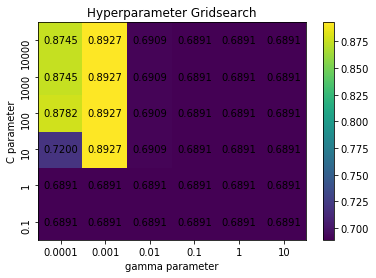

In [11]:
scores = np.array(scores).reshape(len(C_range), len(gamma_range))
for y in range(scores.shape[0]):
    for x in range(scores.shape[1]):
        plt.text(x + 0.5, y + 0.5, '%.4f' % scores[y, x], ha='center', va='center',)
plt.colorbar(plt.pcolor(scores))
plt.title('Hyperparameter Gridsearch')
plt.xlabel('gamma parameter')
plt.ylabel('C parameter')
plt.xticks(np.arange(len(gamma_range))+0.5, gamma_range)
plt.yticks(np.arange(len(C_range))+0.5, C_range, rotation=90)
plt.show()

## Question 4
Train your SVM model by the best parameters you found from question 2 on the whole training set and evaluate the performance on the test set. **You accuracy should over 0.85**

In [12]:
best_model = SVC(C=best_C, kernel='rbf', gamma=best_gamma)
best_model.fit(x_train, y_train)
y_pred = best_model.predict(x_test)
print("Accuracy score: ", accuracy_score(y_pred, y_test))

Accuracy score:  0.8958333333333334


## Question 5
Compare the performance of each model you have implemented from HW1

### HW1

In [13]:
train_df = pd.read_csv("../HW1/train_data.csv")
x_train = train_df['x_train'].to_numpy().reshape(-1,1)
y_train = train_df['y_train'].to_numpy().reshape(-1,1)

test_df = pd.read_csv("../HW1/test_data.csv")
x_test = test_df['x_test'].to_numpy().reshape(-1,1)
y_test = test_df['y_test'].to_numpy().reshape(-1,1)

print(x_train.shape)
print(y_train.shape)

(500, 1)
(500, 1)


In [14]:
class LinearRegression():
    def __init__(self, learning_rate=0.001, batch_size=32, n_epochs=100):
        self.lr = learning_rate
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.loss_history = []

    def fit(self, X, y):
        self.beta0 = np.random.rand(X.shape[1])
        self.beta1 = np.random.rand(1)
        for epoch in range(self.n_epochs):
            loss = 0
            for i in range(0, len(X), self.batch_size):
                # Get batch data
                x_batch = X[i:i+self.batch_size]
                y_batch = y[i:i+self.batch_size]

                # Get preidction & Loss
                y_pred = (x_batch*self.beta0) + self.beta1
                loss = y_pred - y_batch

                # Calculate gradient
                gradient_beta0 = 2*np.sum(x_batch * loss) / len(x_batch)
                gradient_beta1 = 2*np.sum(loss) / len(x_batch)

                # Update weights
                self.beta0 = self.beta0 - self.lr*gradient_beta0
                self.beta1 = self.beta1 - self.lr*gradient_beta1
                self.loss_history.append(self.MSE(y_pred, y_batch))

    def MSE(self, x, y):
        mse = np.mean((x-y) ** 2)
        return mse

    def predict(self, x):
        prediction = x * self.beta0 + self.beta1
        return prediction

In [15]:
lr_model = LinearRegression(learning_rate=0.01, batch_size=len(x_train), n_epochs=500)
lr_model.fit(x_train, y_train)
y_lr_pred = lr_model.predict(x_test)

In [16]:
y_train = y_train.reshape((500,))
kfold_data = cross_validation(x_train, y_train, k=5)
# C_range = [0.1, 1, 10, 100, 1000, 10000, 100000]
C_range = [0.1, 1, 10, 100, 1000]
gamma_range = [0.00001, 0.0001, 0.001, 0.01, 0.1]
best_acc, best_C, best_gamma = 0, 0, 0
scores = []
for C in C_range:
    for gamma in gamma_range:
        total = 0
        for i in range(len(kfold_data)):
            clf = SVR(C=C, kernel='rbf', gamma=gamma)
            clf.fit(x_train[kfold_data[i][0]], y_train[kfold_data[i][0]])
            total += clf.score(x_train[kfold_data[i][1]], y_train[kfold_data[i][1]])
        acc = total / len(kfold_data)
        scores.append(acc)
        if acc >= best_acc:
            best_acc, best_C, best_gamma = acc, C, gamma
#         print("C = " + str(C) + ", gamma = " + str(gamma) + ", acc = " + str(acc) + ": ")
print("The best parameters are C = %0.1f, gamma = %.4f with a score of %f" % (best_C, best_gamma, best_acc))

The best parameters are C = 1000.0, gamma = 0.0010 with a score of 0.702576


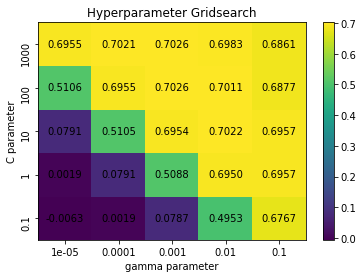

In [17]:
scores = np.array(scores).reshape(len(C_range), len(gamma_range))
for y in range(scores.shape[0]):
    for x in range(scores.shape[1]):
        plt.text(x + 0.5, y + 0.5, '%.4f' % scores[y, x], ha='center', va='center',)
plt.colorbar(plt.pcolor(scores))
plt.title('Hyperparameter Gridsearch')
plt.xlabel('gamma parameter')
plt.ylabel('C parameter')
plt.xticks(np.arange(len(gamma_range))+0.5, gamma_range)
plt.yticks(np.arange(len(C_range))+0.5, C_range, rotation=90)
plt.show()

In [18]:
best_model = SVR(C=best_C, kernel='rbf', gamma=best_gamma)
best_model.fit(x_train, y_train)
y_svm_pred = best_model.predict(x_test)
y_svm_pred = y_svm_pred.reshape((100, 1))
print("Square error of Linear regression: ", lr_model.MSE(y_test, y_lr_pred))
print("Square error of SVM regresssion model: ", lr_model.MSE(y_test, y_svm_pred))

Square error of Linear regression:  0.06870280209670866
Square error of SVM regresssion model:  0.07200436935358709
